In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
import time
import os
import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=5000
saveFreq=20
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16
kernel_size=4
stride=2
padding=1

hidden1=128 #Number of channels in hidden layer 1
hidden2=256 
hidden3=512
hidden4=1024
hidden5=1024
fc_dim1=1024*16*16
fc_dim2=1024
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# clfweight=20
advWeight=2
# randFeatureSubset=None
kl_weight=0.0000001
model_str='cnn_vae'
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
switchFreq=20
diamThresh_mul=512
minThresh_mul=6
overlap=int(diamThresh_mul*0.15)
name='all_thresh12min6_02_overlap15'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnn_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnn_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnn_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

imageslist={}
for s in sampleidx.keys():
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=True,minCutoff=minThresh_mul,seed=seed)
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    elif 'eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='cnn_vae':
    model = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=mse

if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
        
if use_cuda:
    model.cuda()
    if adv:
        modelAdv.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    for batch_idx, trainInput in enumerate(trainInputloader):
#         print(batch_idx)
        if torch.sum(trainInput)==0:
            print('all zeros '+str(batch_idx))

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerVAEXA.zero_grad()

        recon, z, mu, logvar = model(trainInput)

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train 
        if torch.isnan(torch.sum(loss_kl_train)):
            print('kl '+str(batch_idx))
        if torch.isnan(torch.sum(mu)):
            print('mu '+str(batch_idx))
        if torch.isnan(torch.sum(logvar)):
            print('logvar '+str(batch_idx))
        if torch.isnan(torch.sum(z)):
            print('z '+str(batch_idx))
        if torch.isnan(torch.sum(loss_x_train)):
            print('x loss '+str(batch_idx))
        if torch.isnan(torch.sum(trainInput)):
            print('x input '+str(batch_idx))
        if torch.isnan(torch.sum(recon)):
            print('x recon '+str(batch_idx))
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
            loss+=loss_adv_train*advWeight
        loss.backward()
        optimizerVAEXA.step()

    loss_kl_train_all=loss_kl_train_all/len(trainInputloader.dataset)
    loss_x_train_all=loss_x_train_all/len(trainInputloader.dataset)
    loss_all=loss_all/len(trainInputloader.dataset)
    
    model.eval()
    loss_x_val_all=0
    for batch_idx, valInput in enumerate(valInputloader):
        if use_cuda:
            valInput=valInput.cuda().float()
        recon,z, mu, logvar = model(valInput)

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            advOut=modelAdv(z)

        loss_x_val_all+=loss_x(recon, valInput).item()

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
            loss_val+=loss_adv_val*advWeight
    loss_x_val_all=loss_x_val_all/len(valInputloader.dataset)
    
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_x_val: {:.4f}'.format(loss_x_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss_all,loss_kl_train_all,loss_x_train_all,loss_x_val_all      

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
    trainInputnp, valInputnp, _=imageslist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    
    trainInputloader=DataLoader(trainInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    valInputloader=DataLoader(valInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    
    if adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_x_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 0.2321 loss_kl_train: 2238994.7747 loss_x_train: 0.0082 loss_x_val: 0.0015 time: 76.4208s
control13 Epoch: 0001 loss_train: 7.6978 loss_kl_train: 76939333.7182 loss_x_train: 0.0039 loss_x_val: 0.0014 time: 77.4557s
control13 Epoch: 0002 loss_train: 17.0957 loss_kl_train: 170914354.2235 loss_x_train: 0.0043 loss_x_val: 0.0014 time: 77.8888s
control13 Epoch: 0003 loss_train: 6.1585 loss_kl_train: 61546367.3963 loss_x_train: 0.0038 loss_x_val: 0.0015 time: 78.0398s
control13 Epoch: 0004 loss_train: 0.0037 loss_kl_train: 2726.9174 loss_x_train: 0.0035 loss_x_val: 0.0016 time: 78.1402s
control13 Epoch: 0005 loss_train: 2026.3750 loss_kl_train: 20263720045.0246 loss_x_train: 0.0030 loss_x_val: 0.0015 time: 78.1390s
control13 Epoch: 0006 loss_train: 4.1305 loss_kl_train: 41282106.0346 loss_x_train: 0.0023 loss_x_val: 0.0014 time: 78.1377s
control13 Epoch: 0007 loss_train: 11108.2715 loss_kl_train: 111082688874.1597 loss_x_train: 0.0022 loss_x_val: 0.0014 time

control8 Epoch: 0067 loss_train: 0.0003 loss_kl_train: 1283.5311 loss_x_train: 0.0001 loss_x_val: 0.0005 time: 80.0552s
control8 Epoch: 0068 loss_train: 0.0001 loss_kl_train: 166.2301 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0588s
control8 Epoch: 0069 loss_train: 0.0001 loss_kl_train: 164.4862 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0745s
control8 Epoch: 0070 loss_train: 0.0001 loss_kl_train: 165.6381 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0652s
control8 Epoch: 0071 loss_train: 0.0001 loss_kl_train: 162.6936 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0597s
control8 Epoch: 0072 loss_train: 0.0002 loss_kl_train: 1344.6745 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0290s
control8 Epoch: 0073 loss_train: 0.0002 loss_kl_train: 507.3046 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0773s
control8 Epoch: 0074 loss_train: 0.0003 loss_kl_train: 1457.7959 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.0938s
control8 Epoch: 0075 loss_train: 0.0001 loss_

disease8 Epoch: 0135 loss_train: 0.0001 loss_kl_train: 124.5857 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.2813s
disease8 Epoch: 0136 loss_train: 0.8511 loss_kl_train: 8509935.7520 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.2564s
disease8 Epoch: 0137 loss_train: 0.0372 loss_kl_train: 370903.4827 loss_x_train: 0.0001 loss_x_val: 0.0004 time: 78.2778s
disease8 Epoch: 0138 loss_train: 0.0001 loss_kl_train: 328.2971 loss_x_train: 0.0001 loss_x_val: 0.0004 time: 78.2749s
disease8 Epoch: 0139 loss_train: 0.0001 loss_kl_train: 121.3459 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.2933s
control8 Epoch: 0140 loss_train: 0.0004 loss_kl_train: 2331.6603 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 80.1084s
control8 Epoch: 0141 loss_train: 5.2930 loss_kl_train: 52928764.8919 loss_x_train: 0.0001 loss_x_val: 0.0015 time: 79.8931s
control8 Epoch: 0142 loss_train: 0.0048 loss_kl_train: 46541.2174 loss_x_train: 0.0001 loss_x_val: 0.0013 time: 80.0782s
control8 Epoch: 0143 loss_train: 

disease8 Epoch: 0203 loss_train: 0.0001 loss_kl_train: 416.2535 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.3170s
disease8 Epoch: 0204 loss_train: 0.0001 loss_kl_train: 253.7008 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.3195s
disease8 Epoch: 0205 loss_train: 0.0001 loss_kl_train: 252.5442 loss_x_train: 0.0001 loss_x_val: 0.0003 time: 78.3502s
disease8 Epoch: 0206 loss_train: 0.0001 loss_kl_train: 262.1981 loss_x_train: 0.0001 loss_x_val: 0.0003 time: 78.3499s
disease8 Epoch: 0207 loss_train: 0.0004 loss_kl_train: 2993.9548 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.3375s
disease8 Epoch: 0208 loss_train: 0.0001 loss_kl_train: 303.7614 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.3171s
disease8 Epoch: 0209 loss_train: 0.0001 loss_kl_train: 441.5374 loss_x_train: 0.0001 loss_x_val: 0.0004 time: 78.3089s
disease8 Epoch: 0210 loss_train: 0.0001 loss_kl_train: 262.9203 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.3193s
disease8 Epoch: 0211 loss_train: 0.0001 loss_kl

disease13 Epoch: 0271 loss_train: 163.9391 loss_kl_train: 1639389669.4624 loss_x_train: 0.0001 loss_x_val: 0.0005 time: 88.6600s
disease13 Epoch: 0272 loss_train: 16.5190 loss_kl_train: 165189383.8180 loss_x_train: 0.0001 loss_x_val: 0.0013 time: 88.6690s
disease13 Epoch: 0273 loss_train: 0.1719 loss_kl_train: 1717535.6517 loss_x_train: 0.0001 loss_x_val: 0.0011 time: 88.6789s
disease13 Epoch: 0274 loss_train: 0.0007 loss_kl_train: 6401.5099 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.6919s
disease13 Epoch: 0275 loss_train: 0.0006 loss_kl_train: 5427.5850 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.7062s
disease13 Epoch: 0276 loss_train: 0.0005 loss_kl_train: 4589.4991 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.6919s
disease13 Epoch: 0277 loss_train: 0.0005 loss_kl_train: 3934.9692 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.6814s
disease13 Epoch: 0278 loss_train: 0.0005 loss_kl_train: 4146.3328 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.6615s
disease13 Epoch

disease13 Epoch: 0340 loss_train: 0.0001 loss_kl_train: 230.6198 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.8443s
disease13 Epoch: 0341 loss_train: 0.0001 loss_kl_train: 475.1125 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.6210s
disease13 Epoch: 0342 loss_train: 0.0545 loss_kl_train: 543850.4268 loss_x_train: 0.0001 loss_x_val: 0.0012 time: 88.7500s
disease13 Epoch: 0343 loss_train: 0.1654 loss_kl_train: 1652910.9936 loss_x_train: 0.0001 loss_x_val: 0.0013 time: 88.7920s
disease13 Epoch: 0344 loss_train: 0.0343 loss_kl_train: 342298.7907 loss_x_train: 0.0001 loss_x_val: 0.0003 time: 88.7858s
disease13 Epoch: 0345 loss_train: 0.0001 loss_kl_train: 365.7031 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.7868s
disease13 Epoch: 0346 loss_train: 0.0001 loss_kl_train: 288.1413 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 88.7639s
disease13 Epoch: 0347 loss_train: 0.0166 loss_kl_train: 165078.8388 loss_x_train: 0.0001 loss_x_val: 0.0007 time: 88.7492s
disease13 Epoch: 0348 loss_

control13 Epoch: 0409 loss_train: 0.0001 loss_kl_train: 82.8335 loss_x_train: 0.0000 loss_x_val: 0.0002 time: 78.0610s
control13 Epoch: 0410 loss_train: 0.0001 loss_kl_train: 82.4433 loss_x_train: 0.0000 loss_x_val: 0.0002 time: 78.0671s
control13 Epoch: 0411 loss_train: 0.0001 loss_kl_train: 82.5345 loss_x_train: 0.0000 loss_x_val: 0.0003 time: 78.0573s
control13 Epoch: 0412 loss_train: 0.0001 loss_kl_train: 82.6828 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.0634s
control13 Epoch: 0413 loss_train: 0.0001 loss_kl_train: 83.0577 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.0462s
control13 Epoch: 0414 loss_train: 0.0001 loss_kl_train: 83.6732 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.0302s
control13 Epoch: 0415 loss_train: 0.0001 loss_kl_train: 84.3001 loss_x_train: 0.0001 loss_x_val: 0.0002 time: 78.0298s
control13 Epoch: 0416 loss_train: 0.0012 loss_kl_train: 11683.2213 loss_x_train: 0.0001 loss_x_val: 0.0004 time: 78.0303s
control13 Epoch: 0417 loss_train: 0.0001 loss

KeyboardInterrupt: 

In [7]:
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


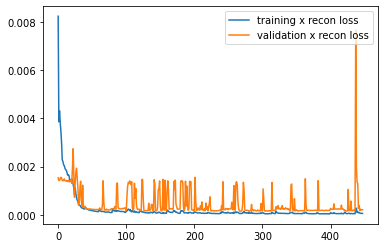

In [9]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,3000))
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [10]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_x_ep[:447])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]

280

In [11]:
testepoch=400
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    _, _, testInputnp=imageslist[s]
    
    testInputloader=DataLoader(testInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    loss_x_test_all=0
    for batch_idx, testInput in enumerate(testInputloader):
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = model(testInput)
        
        if adv and (s in list(sampleLabellist_ae.keys())):
            sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_x_test_all+=loss_x(recon, testInput).item()
    loss_x_test_all=loss_x_test_all/len(testInputloader.dataset)

    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_x_test: {:.4f}'.format(loss_x_test_all))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
   

disease13
test results loss_x_test: 0.0002
control13
test results loss_x_test: 0.0002
disease8
test results loss_x_test: 0.0002
control8
test results loss_x_test: 0.0002
